In [54]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 
pd.options.display.float_format = '{:,.2f}'.format

start = time.perf_counter()

In [55]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv') 
# df = pd.read_csv('jammedaxis27109-infinite-matchhistory.csv')
# df.info()
# df.describe().transpose()

In [56]:
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'] > '2024-02-04']

df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['DamageRatio'] = df['DamageDone'] / df['DamageTaken']
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
## Per 10 Mins and Excess
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']

## Lifetime
df['LifetimeKD'] = df['Kills'].cumsum() / df['Deaths'].cumsum()
df['LifetimeDmgRatio'] = df['DamageDone'].cumsum() / df['DamageTaken'].cumsum()
df['LifetimeAcc'] = df['ShotsLanded'].cumsum() / df['ShotsFired'].cumsum() * 100
df['LifetimeBodyPct'] = df['KillsBody'].cumsum() / df['Kills'].cumsum() *100
df['LifetimeMeleePct'] = df['KillsMelee'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeHSPct'] = df['KillsHeadshot'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimeGrenadePct'] = df['KillsGrenade'].cumsum() / df['Kills'].cumsum() * 100
df['LifetimePowerPct'] = df['KillsPower'].cumsum() / df['Kills'].cumsum() * 100

df['Map'] = df['Map'].str.replace(' - Ranked', '')

df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'WasAtStart', 'WasAtEnd',
            'WasInProgressJoin', 'AssistsEmp', 'AssistsDriver', 'AssistsCallout', 'VehicleDestroys',
            'VehicleHijacks', 'Perfects', 'PreCsr'],axis=1)

dfr = df[df['Playlist'] == 'Ranked Arena']
dfr['Csr'] = dfr['PostCsr'].replace(0, method='ffill')
dfr = dfr[dfr['Outcome'] != 'Draw']
dfr = dfr[dfr['Outcome'] != 'Left']
dfr['Outcome'] = dfr['Outcome'].map({'Win': 1, 'Loss': 0})
dfr['LifetimeWinRate'] = (dfr['Outcome'].cumsum() / 
                           (dfr['Outcome'].cumsum() + 
                            dfr['Outcome'].eq(0).cumsum())).fillna(0)
dfr = dfr.drop(['Playlist', 'PostCsr'], axis=1).reset_index()
# dfr.loc[:4, 'Csr'] = 808
dfr.to_csv('dfNS.csv')
dfr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               94 non-null     int64         
 1   Date                94 non-null     datetime64[ns]
 2   SeasonNumber        94 non-null     int64         
 3   SeasonVersion       94 non-null     int64         
 4   Map                 94 non-null     object        
 5   Category            94 non-null     object        
 6   Rank                94 non-null     int64         
 7   Outcome             94 non-null     int64         
 8   Accuracy            94 non-null     float64       
 9   DamageDone          94 non-null     int64         
 10  DamageTaken         94 non-null     int64         
 11  ShotsFired          94 non-null     int64         
 12  ShotsLanded         94 non-null     int64         
 13  ShotsMissed         94 non-null     int64         
 

In [57]:
dfr.tail(2)

,index,Date,SeasonNumber,SeasonVersion,Map,Category,Rank,Outcome,Accuracy,DamageDone,...,LifetimeKD,LifetimeDmgRatio,LifetimeAcc,LifetimeBodyPct,LifetimeMeleePct,LifetimeHSPct,LifetimeGrenadePct,LifetimePowerPct,Csr,LifetimeWinRate
92,786,2024-02-28 04:49:28,6,1,Solitude,King of the Hill,1,1,54.17,749,...,1.22,1.23,50.30,24.97,9.31,55.05,7.08,3.60,1010,0.55
93,787,2024-02-28 04:56:16,6,1,Solitude,Slayer,4,1,54.85,4462,...,1.22,1.23,50.34,24.85,9.30,55.24,7.03,3.58,1018,0.55


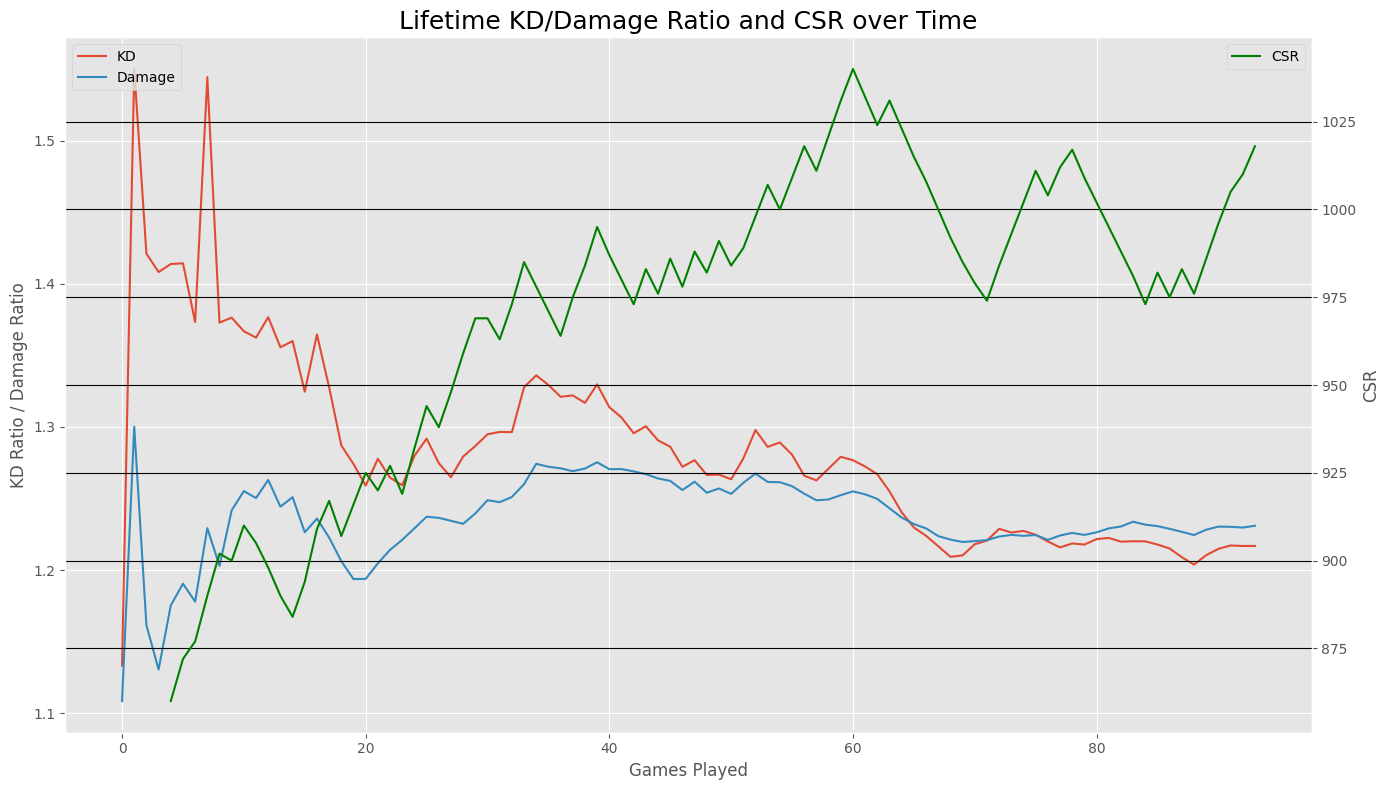

In [58]:
# Smooth the LifetimeWinRate using a 10-game moving average
# dfr['SmoothedAccuracy'] = dfr['Accuracy'].rolling(window=25).mean()

plt.figure(figsize=(14,8))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(dfr['LifetimeKD'], label='KD' )
ax1.plot(dfr['LifetimeDmgRatio'], label='Damage')
ax2.plot(dfr['Csr'][4:], color='green', label='CSR')
ax1.set_title('Lifetime KD/Damage Ratio and CSR over Time', fontsize=18)
ax1.set_xlabel('Games Played')
ax1.set_ylabel('KD Ratio / Damage Ratio')
ax2.set_ylabel('CSR')
# max_y_value = df['LifetimeAcc'].max()
ax1.yaxis.grid(True)
ax2.yaxis.grid(True, color='black')
# ax2.set_yticks(np.arange(47, max_y_value, 0.5))
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatiosAcc.png', dpi=300)
plt.show()

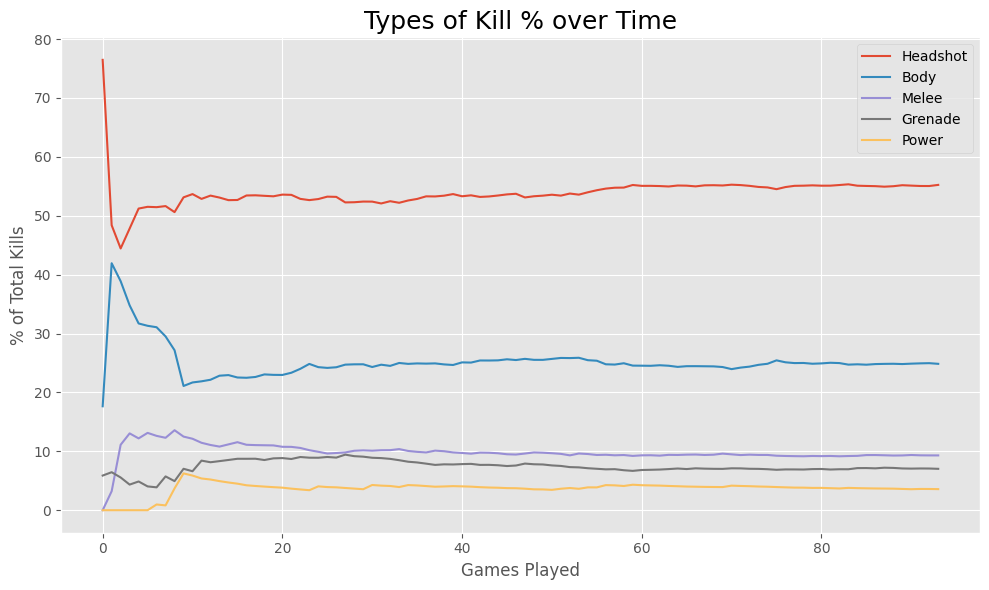

In [59]:
plt.figure(figsize=(10,6))
plt.plot(dfr['LifetimeHSPct'], label='Headshot')
plt.plot(dfr['LifetimeBodyPct'], label='Body')
plt.plot(dfr['LifetimeMeleePct'], label='Melee')
plt.plot(dfr['LifetimeGrenadePct'], label='Grenade')
plt.plot(dfr['LifetimePowerPct'], label='Power')
plt.title('Types of Kill % over Time', fontsize=18)
plt.xlabel('Games Played')
plt.ylabel('% of Total Kills')
plt.legend(loc='best')
plt.grid(True, axis='y')
plt.tight_layout()
# plt.savefig('Plots/DamKDRatios.png', dpi=300)
plt.show()

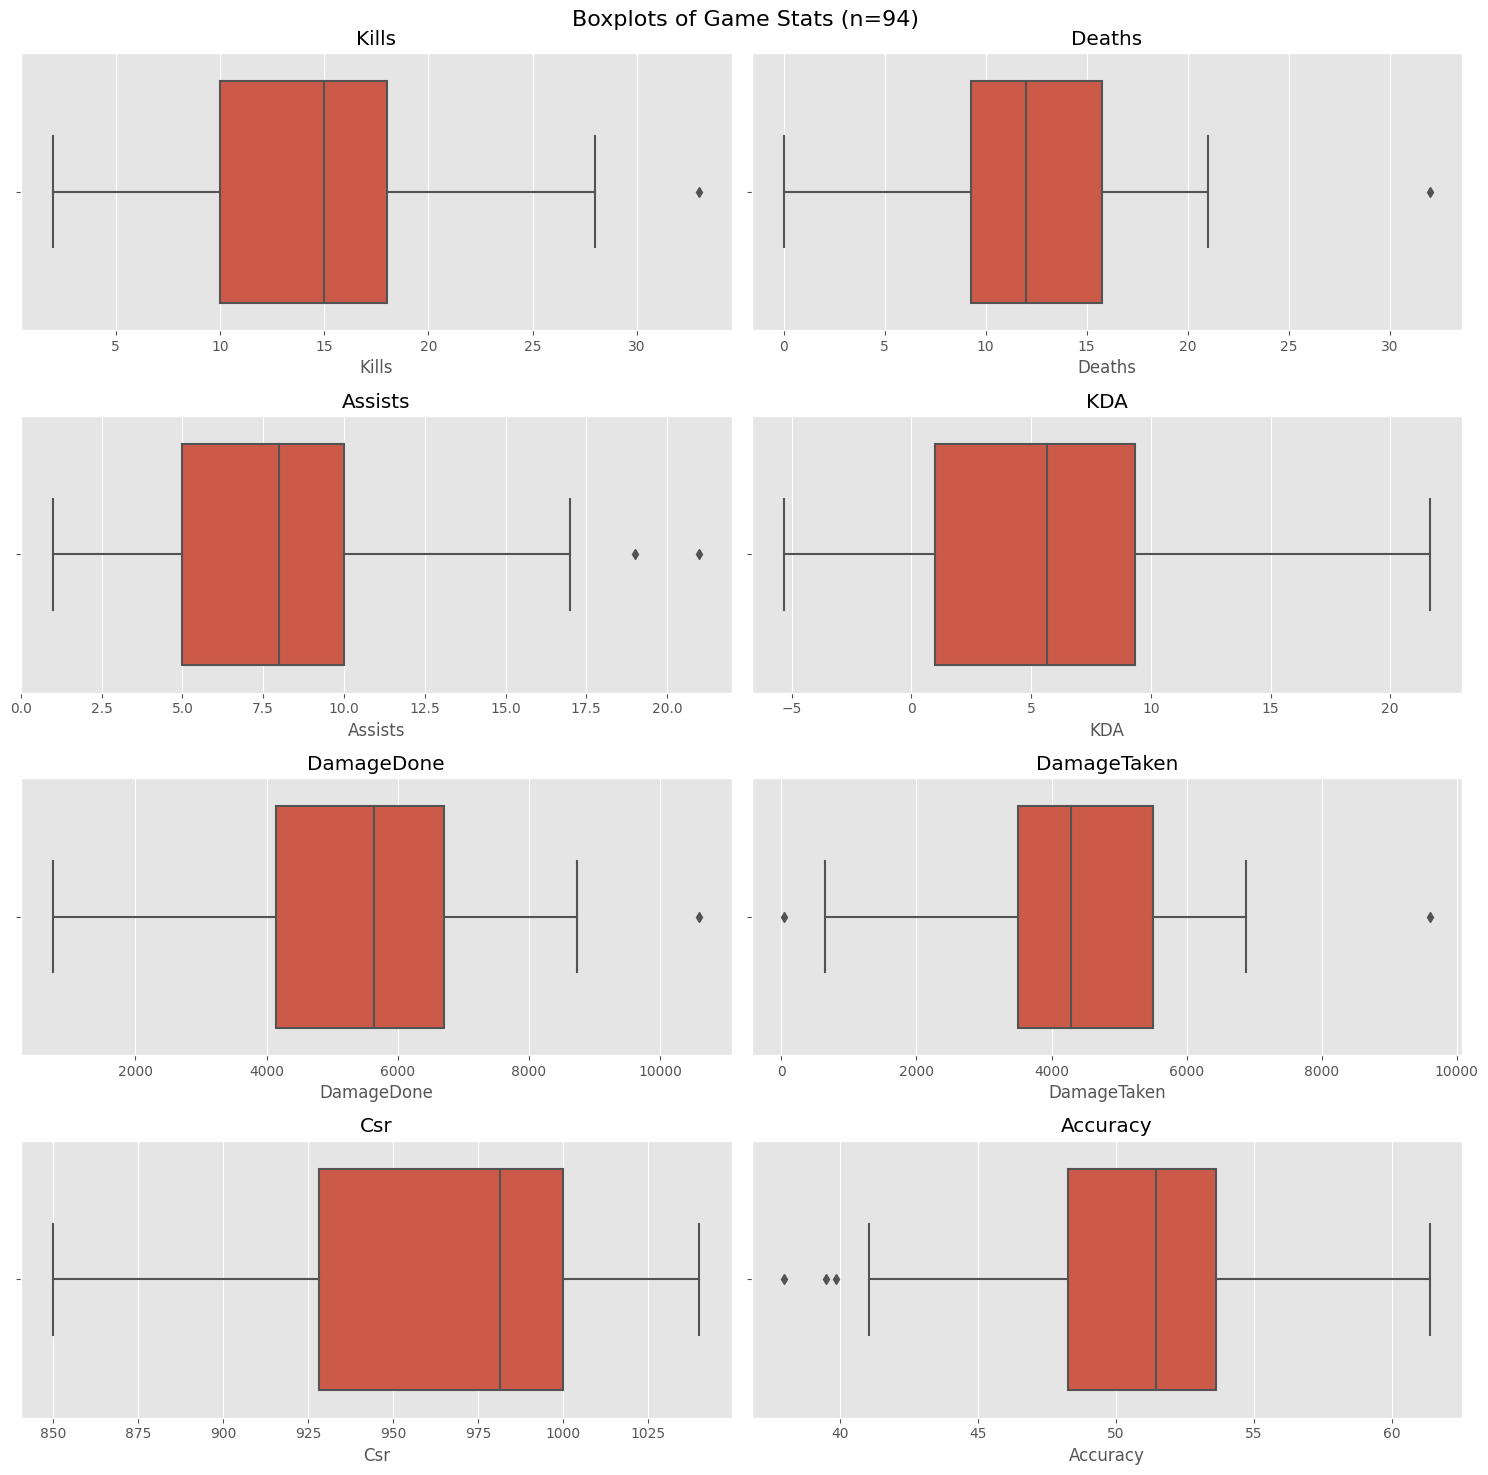

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
columns = ['Kills', 'Deaths', 'Assists', 'KDA', 'DamageDone', 'DamageTaken',
            'Csr', 'Accuracy']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Plot each column in a separate boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=dfr[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.suptitle(f'Boxplots of Game Stats (n={len(dfr)})', fontsize=16)
plt.tight_layout()
# plt.savefig('Plots/Boxplots.png', dpi=300)
plt.show()


In [70]:
dfrcc = dfr.groupby(['Category','Map']).agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'ShotsLanded' : 'sum',
                                             'ShotsFired' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             'LengthMinutes': 'sum',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['Accuracy'] = (dfrcc['ShotsLanded'] / dfrcc['ShotsFired']) *100
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Kills/10Min'] = dfrcc['Kills'] / dfrcc['LengthMinutes'] * 10
dfrcc['Deaths/10Min'] = dfrcc['Deaths'] / dfrcc['LengthMinutes'] * 10
dfrcc['Assists/10Min'] = dfrcc['Assists'] / dfrcc['LengthMinutes'] * 10
dfrcc['KDA/10Min'] = (dfrcc['Kills/10Min'] + (dfrcc['Assists/10Min'] / 3)) / dfrcc['Deaths/10Min'] 
dfrcc = dfrcc.drop(['ShotsLanded', 'ShotsFired'], axis=1)
# dfrcc = round(dfrcc.sort_values(['Category', 'Map'], ascending=False),2)
dfrcc = round(dfrcc.sort_values('Kills/10Min', ascending=False),2)
dfrcc

Count  Kills  Deaths  Assists  DamageDone  \
Category         Map                                                    
CTF 5 Captures   Aquarius       9    168     112       74       56498   
Strongholds      Solitude       5     98      69       44       29674   
                 Live Fire      4     81      57       32       26354   
Oddball          Streets        3     64      53       37       21961   
Slayer           Solitude       4     47      34       35       18359   
CTF 3 Captures   Empyrean      13    224     186       95       80592   
                 Forbidden      8     96      57       42       32035   
Oddball          Recharge       5     67      54       47       25590   
King of the Hill Recharge       9    135     119       97       53766   
Strongholds      Recharge       2     31      18       17       11038   
Oddball          Live Fire      3     46      42       22       17061   
CTF 3 Captures   Argyle         8    121     101       61       46113   
Slayer           Live Fire      4     41      29       23       13972   
King of the Hill Live Fire      2     33      36       26       13544   
                 Solitude       5     66      62       51       27604   
Slayer           Recharge       2     20      21        9        6994   
                 Streets        5     43      52       31       19680   
                 Aquarius       3     22      31       19       11599   

                            DamageTaken  Winrate  LengthMinutes  Accuracy  \
Category         Map                                                        
CTF 5 Captures   Aquarius         42027     0.78          95.40     54.15   
Strongholds      Solitude         25404     0.60          58.30     52.83   
                 Live Fire        20605     0.25          50.45     55.90   
Oddball          Streets          17845     1.00          42.07     50.73   
Slayer           Solitude         13838     0.75          32.23     48.46   
CTF 3 Captures   Empyrean         68228     0.46         158.00     51.62   
                 Forbidden        23009     0.62          67.73     49.78   
Oddball          Recharge         18878     0.80          48.60     47.93   
King of the Hill Recharge         43790     0.11          98.62     48.64   
Strongholds      Recharge          7893     1.00          22.83     45.81   
Oddball          Live Fire        14865     0.67          34.30     51.36   
CTF 3 Captures   Argyle           34056     0.38          90.37     50.88   
Slayer           Live Fire        11824     1.00          31.02     50.55   
King of the Hill Live Fire        12150     1.00          27.90     51.81   
                 Solitude         21375     0.80          56.50     50.60   
Slayer           Recharge          7149     0.50          18.70     42.43   
                 Streets          18588     0.20          42.13     50.16   
                 Aquarius         11267     0.00          24.38     51.80   

                             KD  DamageRatio  Dmg/Life  ExDmg/Life  \
Category         Map                                                 
CTF 5 Captures   Aquarius  1.50         1.34    504.45      129.21   
Strongholds      Solitude  1.42         1.17    430.06       61.88   
                 Live Fire 1.42         1.28    462.35      100.86   
Oddball          Streets   1.21         1.23    414.36       77.66   
Slayer           Solitude  1.38         1.33    539.97      132.97   
CTF 3 Captures   Empyrean  1.20         1.18    433.29       66.47   
                 Forbidden 1.68         1.39    562.02      158.35   
Oddball          Recharge  1.24         1.36    473.89      124.30   
King of the Hill Recharge  1.13         1.23    451.82       83.83   
Strongholds      Recharge  1.72         1.40    613.22      174.72   
Oddball          Live Fire 1.10         1.15    406.21       52.29   
CTF 3 Captures   Argyle    1.20         1.35    456.56      119.38   
Slayer           Live Fire 1.41         1.18  

In [62]:
dfrcc = dfr.groupby('Category').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Category,,,,,,,,,,,,
Oddball,11,177,149,106,64612,51588,0.82,1.19,1.25,433.64,87.41,0.71
CTF 5 Captures,9,168,112,74,56498,42027,0.78,1.50,1.34,504.45,129.21,0.66
Strongholds,11,210,144,93,67066,53902,0.55,1.46,1.24,465.74,91.42,0.65
Slayer,18,173,167,117,70604,62666,0.50,1.04,1.13,422.78,47.53,0.70
CTF 3 Captures,29,441,344,198,158740,125293,0.48,1.28,1.27,461.45,97.23,0.58
King of the Hill,16,234,217,174,94914,77315,0.44,1.08,1.23,437.39,81.10,0.80


In [63]:
dfrcc = dfr.groupby('Map').agg({'Category': 'count',
                                             'Kills' : 'sum',
                                             'Deaths' : 'sum',
                                             'Assists' : 'sum',
                                             'DamageDone': 'sum',
                                             'DamageTaken': 'sum',
                                             'Outcome': 'mean',
                                             })
dfrcc.rename(columns={'Category': 'Count', 'Outcome': 'Winrate'}, inplace=True)
dfrcc['KD'] = dfrcc['Kills'] / dfrcc['Deaths']
dfrcc['DamageRatio'] = dfrcc['DamageDone'] / dfrcc['DamageTaken']
dfrcc['Dmg/Life'] = dfrcc['DamageDone'] / dfrcc['Deaths']
dfrcc['ExDmg/Life'] = (dfrcc['DamageDone'] - dfrcc['DamageTaken']) / dfrcc['Deaths']
dfrcc['Assists/Life'] = dfrcc['Assists'] / dfrcc['Deaths']
dfrcc = round(dfrcc.sort_values('Winrate', ascending=False),2)
dfrcc

,Count,Kills,Deaths,Assists,DamageDone,DamageTaken,Winrate,KD,DamageRatio,Dmg/Life,ExDmg/Life,Assists/Life
Map,,,,,,,,,,,,
Solitude,14,211,165,130,75637,60617,0.71,1.28,1.25,458.41,91.03,0.79
Live Fire,13,201,164,103,70931,59444,0.69,1.23,1.19,432.51,70.04,0.63
Forbidden,8,96,57,42,32035,23009,0.62,1.68,1.39,562.02,158.35,0.74
Aquarius,12,190,143,93,68097,53294,0.58,1.33,1.28,476.20,103.52,0.65
Streets,8,107,105,68,41641,36433,0.50,1.02,1.14,396.58,49.60,0.65
Empyrean,13,224,186,95,80592,68228,0.46,1.20,1.18,433.29,66.47,0.51
Recharge,18,253,212,170,97388,77710,0.44,1.19,1.25,459.38,92.82,0.80
Argyle,8,121,101,61,46113,34056,0.38,1.20,1.35,456.56,119.38,0.60


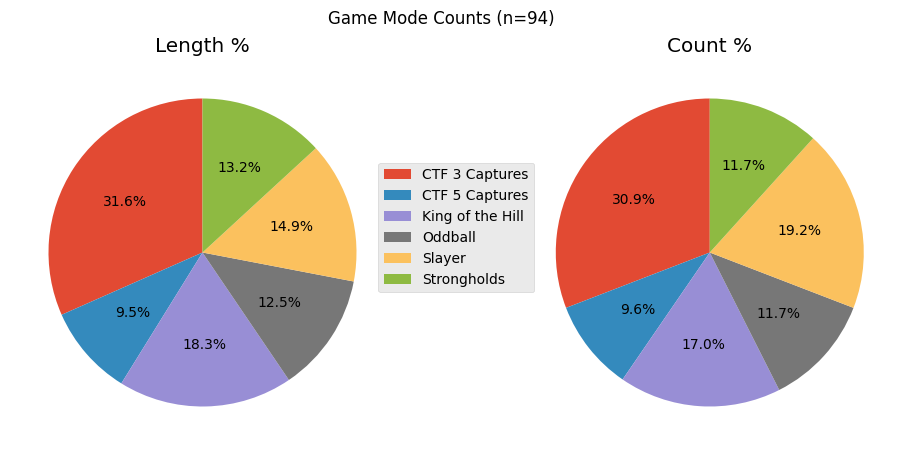

In [64]:
dfrc = dfr.groupby('Category').agg({'LengthMinutes': 'sum', 'Category': 'count'})
dfrc.rename(columns={'Category': 'Count'}, inplace=True)
dfrc['LengthHours'] = round(dfrc['LengthMinutes'] / 60,2)
dfrc['LengthMinutes'] = round(dfrc['LengthMinutes'],2)
dfrc['Length%'] = round(dfrc['LengthMinutes'] / dfrc['LengthMinutes'].sum() * 100,2)
dfrc['Count%'] = round(dfrc['Count'] / dfrc['Count'].sum() * 100,2)
dfrc['TimeMultiple'] = dfrc['Length%'] - dfrc['Count%']
dfrc.sort_values('Length%', ascending=False)

labels = dfrc.index.get_level_values('Category').tolist()
sizes_length = dfrc['Length%'].tolist()
sizes_count = dfrc['Count%'].tolist()
totalcount = dfrc['Count'].sum()


fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a subplot with 1 row and 2 columns
ax[0].pie(sizes_length, labels=None, autopct='%1.1f%%', startangle=90)
ax[1].pie(sizes_count, labels=None, autopct='%1.1f%%', startangle=90)
# Update the title of the plot to include the total game count
fig.suptitle(f'Game Mode Counts (n={totalcount})')

ax[0].set(aspect="equal", title='Length %')
ax[1].set(aspect="equal", title='Count %')
fig.legend(labels, loc="center")

plt.show()

In [65]:
dfw = dfr.loc[dfr['Outcome'] == 1, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

dfl = dfr.loc[dfr['Outcome'] == 0, 
                ['Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'KD', 'DamageDone', 'DamageTaken', 'DamageRatio', 'Outcome', 'ShotsFired', 'ShotsLanded']
                ].sort_values('Kills/10Min', ascending=False)

print('Overall')
print(f'Overall KD: {round(dfr["Kills/10Min"].sum() / dfr["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfr['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfr['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfr['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfr['ShotsLanded'].sum() / dfr['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfr['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfr['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfr['DamageDone'].sum() / dfr['DamageTaken'].sum(),2)}")
print(f"Win-Loss: {(dfr['Outcome']==1).sum()}-{(dfr['Outcome']==0).sum()}")
print('----------------------------')
print('Wins')
print(f'Overall KD: {round(dfw["Kills/10Min"].sum() / dfw["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfw['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfw['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfw['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfw['ShotsLanded'].sum() / dfw['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfw['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfw['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfw['DamageDone'].sum() / dfw['DamageTaken'].sum(),2)}")
print(f"Wins: {(dfw['Outcome']==1).sum()}")
print('----------------------------')
print('Losses')
print(f'Overall KD: {round(dfl["Kills/10Min"].sum() / dfl["Deaths/10Min"].sum(),2)}')
print(f"Average Kills: {round(dfl['Kills/10Min'].mean(),2)}")
print(f"Average Deaths: {round(dfl['Deaths/10Min'].mean(),2)}")
print(f"Average Assists: {round(dfl['Assists/10Min'].mean(),2)}")
print(f"Average Accuracy: {round(dfl['ShotsLanded'].sum() / dfl['ShotsFired'].sum() *100,2)}")
print(f"Average Damage Done: {round(dfl['DamageDone'].mean(),)}")
print(f"Average Damage Taken: {round(dfl['DamageTaken'].mean(),)}")
print(f"Damage Ratio: {round(dfl['DamageDone'].sum() / dfl['DamageTaken'].sum(),2)}")
print(f"Losses: {(dfl['Outcome']==0).sum()}")

Overall
Overall KD: 1.27
Average Kills: 13.92
Average Deaths: 10.95
Average Assists: 7.71
Average Accuracy: 50.85
Average Damage Done: 5451
Average Damage Taken: 4391
Damage Ratio: 1.24
Win-Loss: 52-42
----------------------------
Wins
Overall KD: 1.5
Average Kills: 14.96
Average Deaths: 9.95
Average Assists: 8.09
Average Accuracy: 51.41
Average Damage Done: 5324
Average Damage Taken: 4063
Damage Ratio: 1.31
Wins: 52
----------------------------
Losses
Overall KD: 1.04
Average Kills: 12.63
Average Deaths: 12.2
Average Assists: 7.24
Average Accuracy: 50.22
Average Damage Done: 5610
Average Damage Taken: 4798
Damage Ratio: 1.17
Losses: 42


In [66]:
print(f'Runtime: {time.perf_counter() - start}s')

Runtime: 0.9185310000320897s
